## Pre-processing Mitigation Methods: AIF360



In [1]:
import numpy as np
from numpy.random import choice as np_choice
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from tabulate import tabulate
from IPython.display import Markdown, display
# from sklearn.decomposition import PCA

import fairness_helpers as fh
import global_variables as gv
from xgboost import XGBClassifier
import utilities
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, QuantileTransformer, RobustScaler, StandardScaler,MinMaxScaler

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

In [25]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#### get data

In [3]:
X, X1 = fh.get_aif360_data()

In [4]:
X

1319-0.0  1408-0.0  1329-0.0  \
sex-binary race-binary race-grouped age-binary                                 
0          1           0            1                0.0       1.0       2.0   
1          1           0            1                0.0       3.0       2.0   
0          1           0            1                0.0       3.0       3.0   
1          1           0            1                3.0       3.0       3.0   
                                    0                0.0       3.0       2.0   
...                                                  ...       ...       ...   
                                    1                0.0       3.0       1.0   
0          1           0            1                0.0       1.0       1.0   
1          1           0            0                2.0       1.0       1.0   
0          1           0            1                3.0       3.0       1.0   
1          1           0            1                1.0       2.0       2.0   

                                                1448-0.0  1538-0.0  6142-0.0  \
sex-binary race-binary race-grouped age-binary                                 
0          1           0            1                3.0       2.0       1.0   
1          1           0            1                1.0       0.0       1.0   
0          1           0            1                2.0       1.0       2.0   
1          1           0            1                3.0       0.0       2.0   
                                    0                1.0       0.0       5.0   
...                                                  ...       ...       ...   
                                    1                1.0       2.0       1.0   
0          1           0            1                3.0       2.0       2.0   
1          1           0            0                2.0       2.0       1.0   
0          1           0            1                3.0       0.0       1.0   
1          1           0            1                1.0       0.0       1.0   

                                                2050-0.0  1508-0.0  1339-0.0  \
sex-binary race-binary race-grouped age-binary                                 
0          1           0            1                2.0       3.0       2.0   
1          1           0            1                1.0       2.0       2.0   
0          1           0            1                1.0       2.0       2.0   
1          1           0            1                1.0       2.0       2.0   
                                    0                2.0       2.0       2.0   
...                                                  ...       ...       ...   
                                    1                1.0       1.0       2.0   
0          1           0            1                1.0       1.0       1.0   
1          1           0            0                4.0       2.0       2.0   
0          1           0            1                1.0       2.0       2.0   
1          1           0            1                1.0       2.0       2.0   

                                                30710-0.0  1349-0.0  \
sex-binary race-binary race-grouped age-binary                        
0          1           0            1              0.3400       1.0   
1          1           0            1              3.9400       4.0   
0          1           0            1              0.5500       1.0   
1          1           0            1              0.4500       2.0   
                                    0              0.7500       2.0   
...                                                   ...       ...   
                                    1              1.4500       3.0   
0          1           0            1              2.7500       1.0   
1          1           0            0              0.8500       3.0   
0          1           0            1              3.5700       2.0   
1          1           0            1              2.9031       1.0   

 

#### Step 1. Convert Pandas DataFrame into [BinaryLabelDataset datatype](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html#aif360.datasets.BinaryLabelDataset)

In [5]:
dataset1b = BinaryLabelDataset(df=X1, 
                          label_names=['CVD'], 
                          protected_attribute_names=['sex-binary'])

dataset2b = BinaryLabelDataset(df=X1, 
                          label_names=['CVD'], 
                          protected_attribute_names=['race-binary'])

dataset3b = BinaryLabelDataset(df=X1, 
                          label_names=['CVD'], 
                          protected_attribute_names=['age-binary'])

#### XGBoost Model

In [6]:
df = pd.read_csv('data/entire_imputed.csv')
pd.set_option('display.max_columns', None)
df.drop('Unnamed: 0', axis=1, inplace=True)

X_train, X_val, X_test, y_train, y_val, y_test = utilities.process_features(df, 'CVD', QuantileTransformer(output_distribution='uniform'), one_hot=True, val=True)
X_train, y_train= utilities.resample_data(X_train, y_train, 'under')

n_estimators = 1000

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.01,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="binary:logistic",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=40,
            verbose=20)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-logloss:0.69122
[20]	validation_0-logloss:0.65926
[40]	validation_0-logloss:0.63727
[60]	validation_0-logloss:0.62185
[80]	validation_0-logloss:0.61093
[100]	validation_0-logloss:0.60308
[120]	validation_0-logloss:0.59758
[140]	validation_0-logloss:0.59357
[160]	validation_0-logloss:0.59082
[180]	validation_0-logloss:0.58876
[200]	validation_0-logloss:0.58704
[220]	validation_0-logloss:0.58594
[240]	validation_0-logloss:0.58504
[260]	validation_0-logloss:0.58437
[280]	validation_0-logloss:0.58393
[300]	validation_0-logloss:0.58342
[320]	validation_0-logloss:0.58309
[340]	validation_0-logloss:0.58288
[360]	validation_0-logloss:0.58261
[380]	validation_0-logloss:0.58243
[400]	validation_0-logloss:0.58233
[420]	validation_0-logloss:0.58217
[440]	validation_0-logloss:0.58215
[460]	validation_0-logloss:0.58209
[480]	validation_0-logloss:0.58186
[500]	validation_0-logloss:0.58172
[520]	validation_0-logloss:0.58176
[540]	validation_0-logloss:0.58164
[560]	validation_0-logloss

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [7]:
y_pred_proba = clf_xgb.predict_proba(X_test)[:,1]

#### Split dataset according to protected attributes

In [8]:
from sklearn.model_selection import train_test_split

y = X1['CVD']
X_train, X_test, y_train, y_test = train_test_split(X1.drop('CVD', axis=1), y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

df_test = pd.concat([X_test, y_test], axis=1)

# split dataframe by sex
women_test = df_test[df_test['sex-binary']==0]
men_test = df_test[df_test['sex-binary']==1]

# split dataframe by race-binary
b_white_test = df_test[df_test['race-binary']==1]
b_non_white_test = df_test[df_test['race-binary']==0]

# split dataframe by race-grouped
white_test = df_test[df_test['race-grouped']==0]
black_test = df_test[df_test['race-grouped']==1]
asian_test = df_test[df_test['race-grouped']==2]
mixed_other_test = df_test[df_test['race-grouped']==3]

# split dataframe by age
young_test = df_test[df_test['age-binary']==0]
old_test = df_test[df_test['age-binary']==1]

# sex
X_women = women_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
X_men = men_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
y_women = women_test.loc[:,'CVD']
y_men = men_test.loc[:,'CVD']

# race-binary
Xb_white = b_white_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
Xb_non_white = b_non_white_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
yb_white = b_white_test.loc[:,'CVD']
yb_non_white = b_non_white_test.loc[:,'CVD']

# race-grouped
X_white = white_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
X_black = black_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
X_asian = asian_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
X_other = mixed_other_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
y_white = white_test.loc[:,'CVD']
y_black = black_test.loc[:,'CVD']
y_asian = asian_test.loc[:,'CVD']
y_other = mixed_other_test.loc[:,'CVD']

# age
X_young = young_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
X_old = old_test.drop(fh.protected_attribute_names+['CVD'], axis=1)
y_young = young_test.loc[:,'CVD']
y_old = old_test.loc[:,'CVD']

#### original results

Threshold corresponding to Best balanced accuracy: 0.4822
Best balanced accuracy: 0.6718
Corresponding abs(1-disparate impact) value: 0.5063
Corresponding average odds difference value: -0.2539
Corresponding statistical parity difference value: -0.2366
Corresponding equal opportunity difference value: -0.2950
Corresponding Theil index value: 0.0898


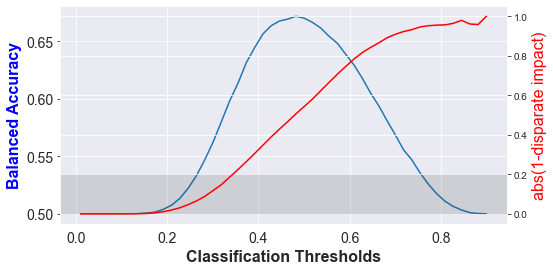

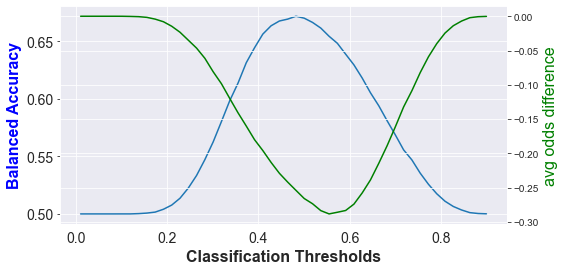

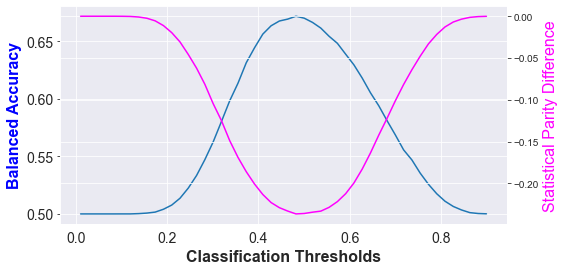

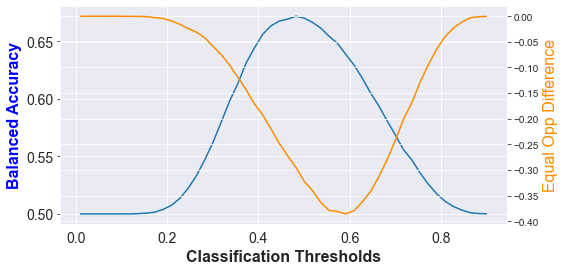

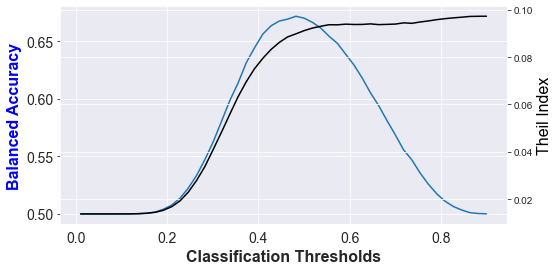

In [9]:
# sex binary

y_boost_prob_women = clf_xgb.predict_proba(X_women)[:,1]
y_boost_prob_men = clf_xgb.predict_proba(X_men)[:,1]

_, _, _, _, _,  _, _, result_og_sex = fh.validate_visualize(pd.concat([women_test, men_test], axis=0), np.concatenate([y_boost_prob_women, y_boost_prob_men], axis=0), 'sex-binary', metric='balanced_accuracy')

Threshold corresponding to Best balanced accuracy: 0.4822
Best balanced accuracy: 0.6718
Corresponding abs(1-disparate impact) value: 0.2170
Corresponding average odds difference value: -0.0678
Corresponding statistical parity difference value: -0.0743
Corresponding equal opportunity difference value: -0.0775
Corresponding Theil index value: 0.0898


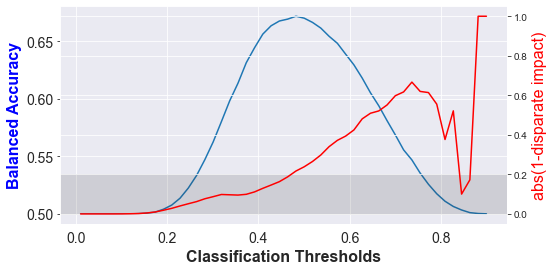

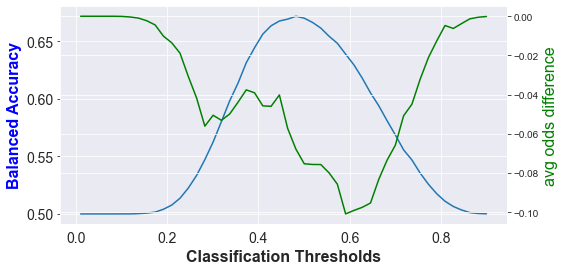

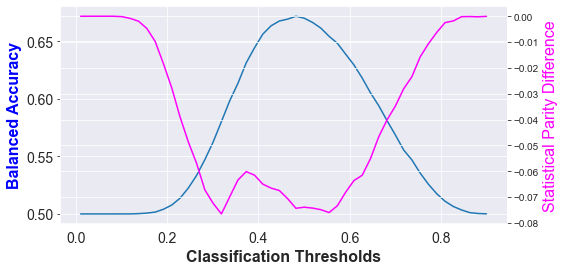

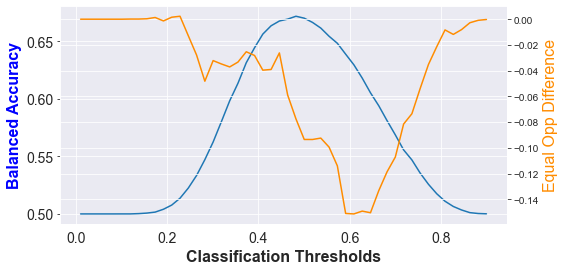

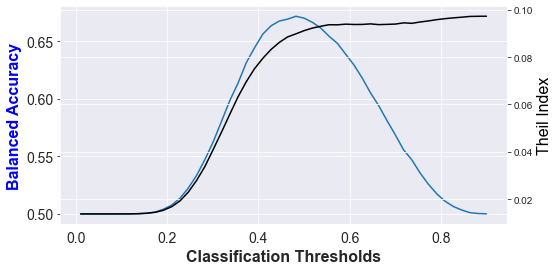

In [10]:
# race binary

yb_boost_prob_white = clf_xgb.predict_proba(Xb_white)[:,1]
yb_boost_prob_non_white = clf_xgb.predict_proba(Xb_non_white)[:,1]

_, _, _, _, _,  _, _, result_og_race = fh.validate_visualize(pd.concat([b_white_test, b_non_white_test], axis=0), np.concatenate([yb_boost_prob_white, yb_boost_prob_non_white], axis=0), 'race-binary', metric='balanced_accuracy')

Threshold corresponding to Best balanced accuracy: 0.4822
Best balanced accuracy: 0.6718
Corresponding abs(1-disparate impact) value: 0.6424
Corresponding average odds difference value: -0.2502
Corresponding statistical parity difference value: -0.2571
Corresponding equal opportunity difference value: -0.2675
Corresponding Theil index value: 0.0898


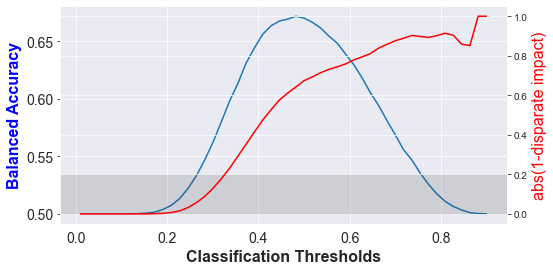

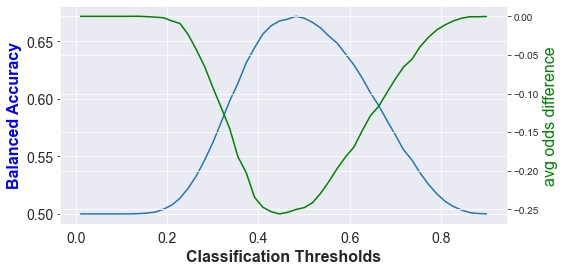

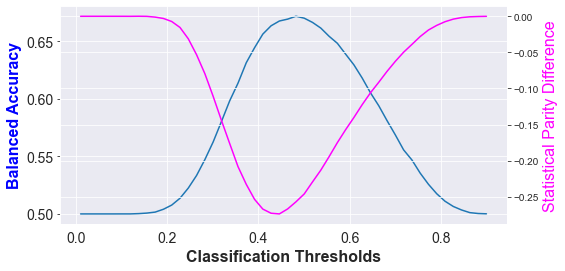

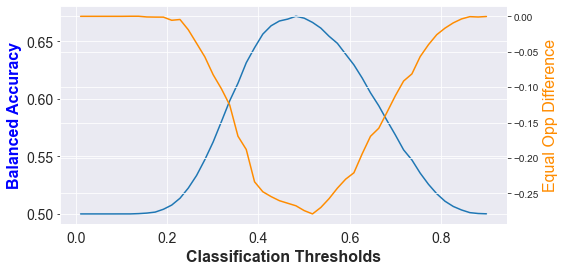

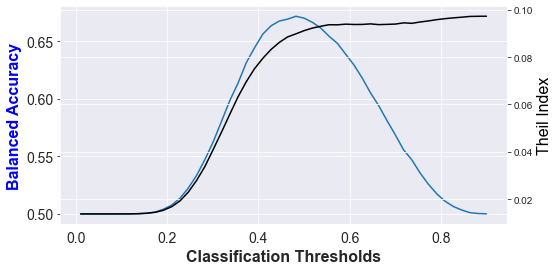

In [11]:
# age binary

y_boost_prob_young = clf_xgb.predict_proba(X_young)[:,1]
y_boost_prob_old = clf_xgb.predict_proba(X_old)[:,1]

_, _, _, _, _,  _, _, result_og_age = fh.validate_visualize(pd.concat([young_test, old_test], axis=0), np.concatenate([y_boost_prob_young, y_boost_prob_old], axis=0), 'age-binary', metric='balanced_accuracy')

### Method 1. Disparate Impact Remover

Edits feature values to increase group fairness while preserving rank-ordering. Must specify the <font color='blue'>repair_level</font> variable to indicate how much group distributions should overlap.

We want the individual rankings within their group to be preserved after repair ie if an individual has the highest ranking in group Q, it will still have the highest ranking in group Q after repair


#### Transform dataset for each protected attribute with Disparate Impact Remover

In [19]:
# transform original dataset

di = DisparateImpactRemover(repair_level = 1.0)
dataset_transf_train = di.fit_transform(dataset1b)
transformed = dataset_transf_train.convert_to_dataframe()[0] # sex

In [21]:
dataset_transf_train2 = di.fit_transform(dataset2b)
transformed2 = dataset_transf_train2.convert_to_dataframe()[0] # race

In [22]:
dataset_transf_train3 = di.fit_transform(dataset3b)
transformed3 = dataset_transf_train3.convert_to_dataframe()[0] # race

In [23]:
# function to process all subgroups into AIF360 datasets

def DI_convert_transform(df, repair, attribute):
    di = DisparateImpactRemover(repair_level = repair)
    dataset = BinaryLabelDataset(df=X1, label_names=['CVD'], protected_attribute_names=[attribute])
    dataset_transf_train = di.fit_transform(dataset)
    transformed = dataset_transf_train.convert_to_dataframe()[0] 
    return transformed

#### retrain model for each transformed dataset

#### sex

In [24]:
X = transformed.drop(['CVD'] , axis=1)
y = transformed.loc[:, 'CVD']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.15, random_state=1)    

X_train, y_train= utilities.resample_data(X_train, y_train, 'under')

In [26]:
# fit
clf_xgb.fit(X_train.drop(['sex-binary', 'race-binary', 'race-grouped', 'age-binary'], axis=1), y_train,
            eval_set=[(X_val.drop(['sex-binary', 'race-binary', 'race-grouped', 'age-binary'], axis=1), y_val)],
            early_stopping_rounds=40,
            verbose=20)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-logloss:0.69126
[20]	validation_0-logloss:0.65998
[40]	validation_0-logloss:0.63846
[60]	validation_0-logloss:0.62333
[80]	validation_0-logloss:0.61263
[100]	validation_0-logloss:0.60479
[120]	validation_0-logloss:0.59928
[140]	validation_0-logloss:0.59530
[160]	validation_0-logloss:0.59233
[180]	validation_0-logloss:0.59019
[200]	validation_0-logloss:0.58863
[220]	validation_0-logloss:0.58755
[240]	validation_0-logloss:0.58668
[260]	validation_0-logloss:0.58599
[280]	validation_0-logloss:0.58535
[300]	validation_0-logloss:0.58491
[320]	validation_0-logloss:0.58470
[340]	validation_0-logloss:0.58443
[360]	validation_0-logloss:0.58414
[380]	validation_0-logloss:0.58381
[400]	validation_0-logloss:0.58360
[420]	validation_0-logloss:0.58350
[440]	validation_0-logloss:0.58328
[460]	validation_0-logloss:0.58316
[480]	validation_0-logloss:0.58317
[500]	validation_0-logloss:0.58312
[520]	validation_0-logloss:0.58295
[540]	validation_0-logloss:0.58306
[555]	validation_0-logloss

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [27]:
y_pred_boost_sex = clf_xgb.predict_proba(X_test.drop(['sex-binary', 'race-binary', 'race-grouped', 'age-binary'], axis=1))[:,1]

In [28]:
women_test = DI_convert_transform(women_test, 1.0, 'sex-binary')

In [30]:
men_test = DI_convert_transform(men_test, 1.0, 'sex-binary')

Threshold corresponding to Best balanced accuracy: 0.5004
Best balanced accuracy: 0.7258
Corresponding abs(1-disparate impact) value: 0.4665
Corresponding average odds difference value: -0.1903
Corresponding statistical parity difference value: -0.2111
Corresponding equal opportunity difference value: -0.1917
Corresponding Theil index value: 0.0795


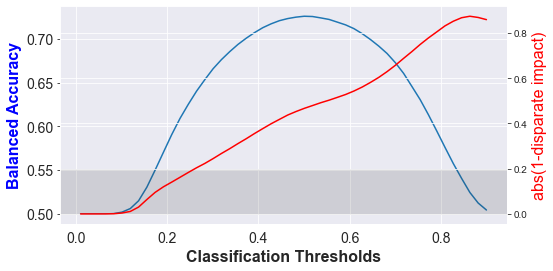

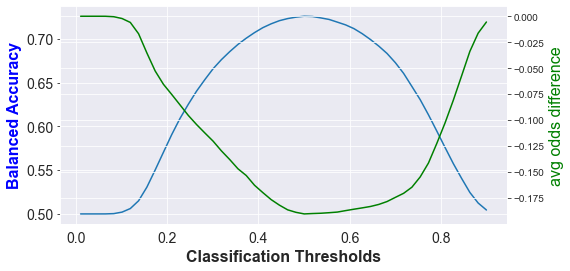

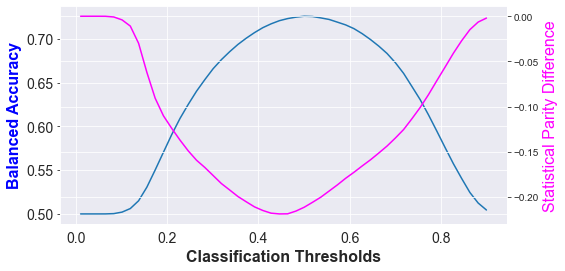

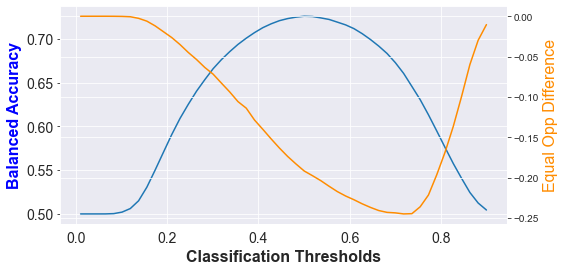

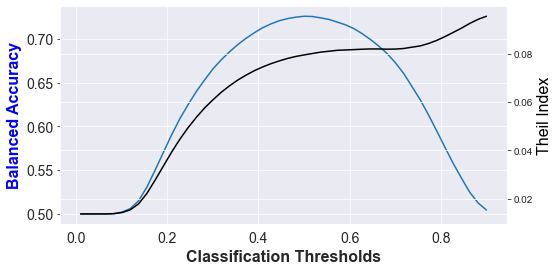

In [31]:
y_pred_boost_sex = clf_xgb.predict_proba(X_test.drop(fh.protected_attribute_names, axis=1))[:,1]
y_boost_prob_women = clf_xgb.predict_proba(women_test.drop(fh.protected_attribute_names+['CVD'], axis=1))[:,1]
y_boost_prob_men = clf_xgb.predict_proba(men_test.drop(fh.protected_attribute_names+['CVD'], axis=1))[:,1]

thresh_arr_best4, best_bal_acc4, DI4, av_odds4, stat_par4,  eq_opp4, theil_4, result = fh.validate_visualize(pd.concat([women_test, men_test], axis=0), np.concatenate([y_boost_prob_women, y_boost_prob_men], axis=0), 'sex-binary', metric='balanced_accuracy')

#### race-binary

In [32]:
X = transformed2.drop(['CVD'] , axis=1)
y = transformed2.loc[:, 'CVD']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.15, random_state=1)    

X_train, y_train= utilities.resample_data(X_train, y_train, 'under')

In [33]:
# fit
clf_xgb.fit(X_train.drop(['sex-binary', 'race-binary', 'race-grouped', 'age-binary'], axis=1), y_train,
            eval_set=[(X_val.drop(['sex-binary', 'race-binary', 'race-grouped', 'age-binary'], axis=1), y_val)],
            early_stopping_rounds=40,
            verbose=20)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-logloss:0.69126
[20]	validation_0-logloss:0.65998
[40]	validation_0-logloss:0.63846
[60]	validation_0-logloss:0.62333
[80]	validation_0-logloss:0.61263
[100]	validation_0-logloss:0.60479
[120]	validation_0-logloss:0.59928
[140]	validation_0-logloss:0.59530
[160]	validation_0-logloss:0.59233
[180]	validation_0-logloss:0.59019
[200]	validation_0-logloss:0.58863
[220]	validation_0-logloss:0.58755
[240]	validation_0-logloss:0.58668
[260]	validation_0-logloss:0.58599
[280]	validation_0-logloss:0.58535
[300]	validation_0-logloss:0.58491
[320]	validation_0-logloss:0.58470
[340]	validation_0-logloss:0.58443
[360]	validation_0-logloss:0.58414
[380]	validation_0-logloss:0.58381
[400]	validation_0-logloss:0.58360
[420]	validation_0-logloss:0.58350
[440]	validation_0-logloss:0.58328
[460]	validation_0-logloss:0.58316
[480]	validation_0-logloss:0.58317
[500]	validation_0-logloss:0.58312
[520]	validation_0-logloss:0.58295
[540]	validation_0-logloss:0.58306
[555]	validation_0-logloss

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [34]:
b_white_test = DI_convert_transform(b_white_test, 1.0, 'race-binary')
b_non_white_test = DI_convert_transform(b_non_white_test, 1.0, 'race-binary')

Threshold corresponding to Best balanced accuracy: 0.5367
Best balanced accuracy: 0.7047
Corresponding abs(1-disparate impact) value: 0.2006
Corresponding average odds difference value: -0.0413
Corresponding statistical parity difference value: -0.0712
Corresponding equal opportunity difference value: -0.0274
Corresponding Theil index value: 0.0829


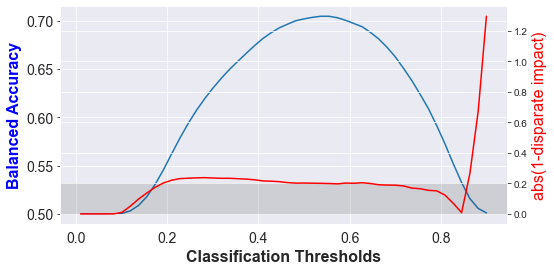

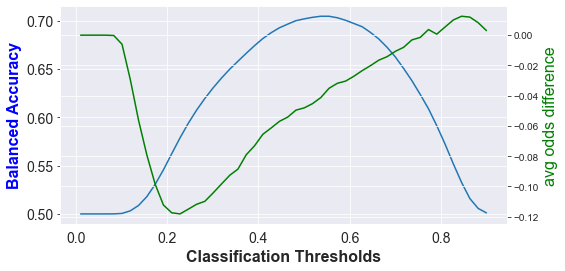

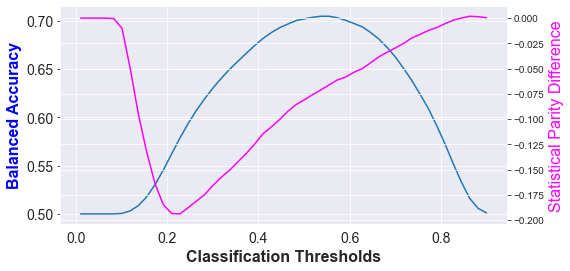

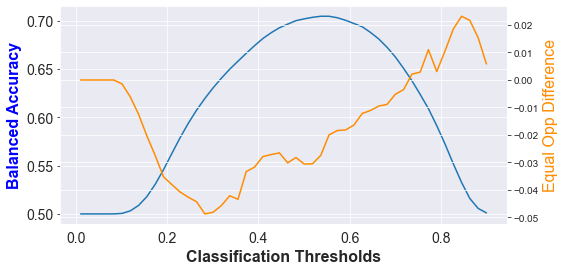

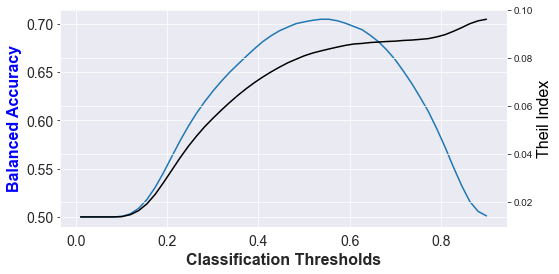

In [35]:
y_pred_boost_race = clf_xgb.predict_proba(X_test.drop(['sex-binary', 'race-binary', 'race-grouped', 'age-binary'], axis=1))[:,1]
y_boost_prob_white = clf_xgb.predict_proba(b_white_test.drop(fh.protected_attribute_names+['CVD'], axis=1))[:,1]
y_boost_prob_non_white = clf_xgb.predict_proba(b_non_white_test.drop(fh.protected_attribute_names+['CVD'], axis=1))[:,1]

_, _, _, _, _,  _, _, result_race = fh.validate_visualize(pd.concat([b_white_test, b_non_white_test], axis=0), np.concatenate([y_boost_prob_white, y_boost_prob_non_white], axis=0), 'race-binary', metric='balanced_accuracy')

#### age

In [36]:
X = transformed3.drop(['CVD'] , axis=1)
y = transformed3.loc[:, 'CVD']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.15, random_state=1)    

X_train, y_train= utilities.resample_data(X_train, y_train, 'under')

In [37]:
# fit
clf_xgb.fit(X_train.drop(['sex-binary', 'race-binary', 'race-grouped', 'age-binary'], axis=1), y_train,
            eval_set=[(X_val.drop(['sex-binary', 'race-binary', 'race-grouped', 'age-binary'], axis=1), y_val)],
            early_stopping_rounds=40,
            verbose=20)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-logloss:0.69126
[20]	validation_0-logloss:0.65998
[40]	validation_0-logloss:0.63846
[60]	validation_0-logloss:0.62333
[80]	validation_0-logloss:0.61263
[100]	validation_0-logloss:0.60479
[120]	validation_0-logloss:0.59928
[140]	validation_0-logloss:0.59530
[160]	validation_0-logloss:0.59233
[180]	validation_0-logloss:0.59019
[200]	validation_0-logloss:0.58863
[220]	validation_0-logloss:0.58755
[240]	validation_0-logloss:0.58668
[260]	validation_0-logloss:0.58599
[280]	validation_0-logloss:0.58535
[300]	validation_0-logloss:0.58491
[320]	validation_0-logloss:0.58470
[340]	validation_0-logloss:0.58443
[360]	validation_0-logloss:0.58414
[380]	validation_0-logloss:0.58381
[400]	validation_0-logloss:0.58360
[420]	validation_0-logloss:0.58350
[440]	validation_0-logloss:0.58328
[460]	validation_0-logloss:0.58316
[480]	validation_0-logloss:0.58317
[500]	validation_0-logloss:0.58312
[520]	validation_0-logloss:0.58295
[540]	validation_0-logloss:0.58306
[556]	validation_0-logloss

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [38]:
young_test = DI_convert_transform(young_test, 1.0, 'race-binary')
old_test = DI_convert_transform(old_test, 1.0, 'race-binary')

Threshold corresponding to Best balanced accuracy: 0.5367
Best balanced accuracy: 0.7047
Corresponding abs(1-disparate impact) value: 0.8814
Corresponding average odds difference value: -0.4222
Corresponding statistical parity difference value: -0.3921
Corresponding equal opportunity difference value: -0.4838
Corresponding Theil index value: 0.0829


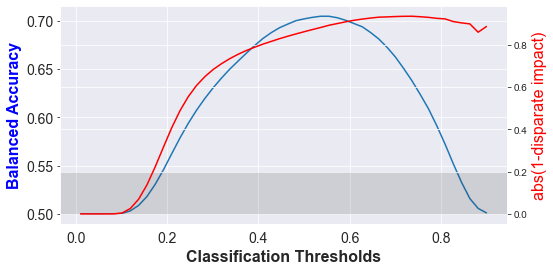

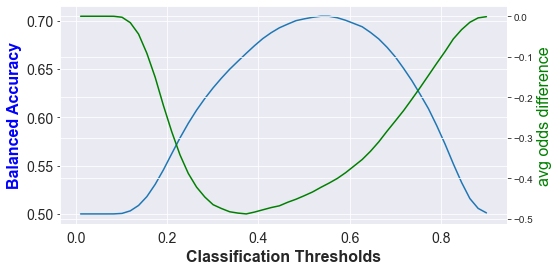

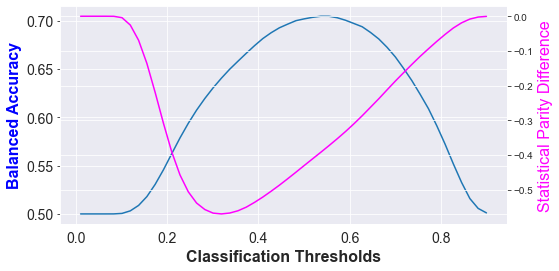

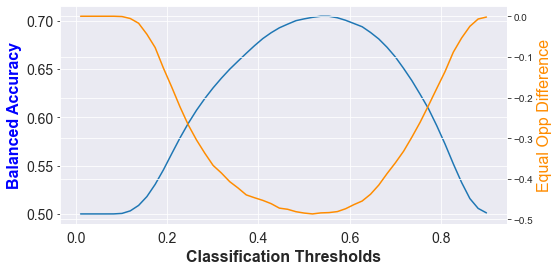

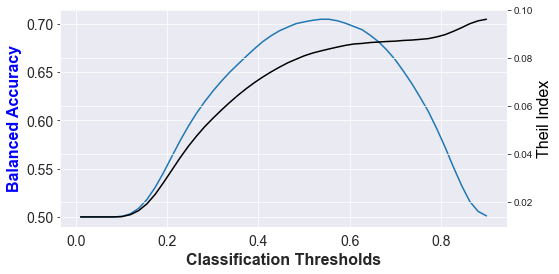

In [39]:
y_pred_boost_age = clf_xgb.predict_proba(X_test.drop(['sex-binary', 'race-binary', 'race-grouped', 'age-binary'], axis=1))[:,1]
y_boost_prob_young = clf_xgb.predict_proba(young_test.drop(fh.protected_attribute_names+['CVD'], axis=1))[:,1]
y_boost_prob_old = clf_xgb.predict_proba(old_test.drop(fh.protected_attribute_names+['CVD'], axis=1))[:,1]

_, _, _, _, _,  _, _, result_age = fh.validate_visualize(pd.concat([young_test, old_test], axis=0), np.concatenate([y_boost_prob_young, y_boost_prob_old], axis=0), 'age-binary', metric='balanced_accuracy')

### make predictions

In [40]:
from sklearn.metrics import accuracy_score

threshold = 0.609388
y_pred_og = (y_pred_proba> threshold).astype(np.double)
y_pred_sex = (y_pred_boost_sex> threshold).astype(np.double)
y_pred_race = (y_pred_boost_race> threshold).astype(np.double)
y_pred_age = (y_pred_boost_age> threshold).astype(np.double)

# get accuracies
acc_og = accuracy_score(y_test, y_pred_og)
acc_int_sex = accuracy_score(y_test, y_pred_sex)
acc_int_race = accuracy_score(y_test, y_pred_race)
acc_int_age = accuracy_score(y_test, y_pred_age)

#### compare Disparate Impact before and after intervention

In [46]:
result_og_0_6_sex = result_og_sex.iloc[33,:]
result_int_0_6_sex  = result.iloc[33,:]

result_og_0_6_race = result_og_race.iloc[33,:]
result_int_0_6_race = result_race.iloc[33,:]

result_og_0_6_age = result_og_age.iloc[33,:]
result_int_0_6_age = result_age.iloc[33,:]

full_results = pd.DataFrame(columns = ['model', 'protected_attribute', 'intervention',  'accuracy']+result.columns.to_list())
full_results.loc[len(full_results.index)] = result_og_0_6_sex
full_results.loc[len(full_results.index)] = result_int_0_6_sex
full_results.loc[len(full_results.index)] = result_og_0_6_race
full_results.loc[len(full_results.index)] = result_int_0_6_race
full_results.loc[len(full_results.index)] = result_og_0_6_age
full_results.loc[len(full_results.index)] = result_int_0_6_age

full_results.iloc[0, :4] = ['XGBoost', 'sex', 'original', acc_og]
full_results.iloc[1, :4] = ['XGBoost', 'sex', 'DI Remover', acc_int_sex]

full_results.iloc[2, :4] = ['XGBoost', 'race-binary', 'original', acc_og]
full_results.iloc[3, :4] = ['XGBoost', 'race-binary', 'DI Remover', acc_int_race]

full_results.iloc[4, :4] = ['XGBoost', 'age-binary', 'original', acc_og]
full_results.iloc[5, :4] = ['XGBoost', 'age-binary', 'DI Remover', acc_int_age]


full_results.to_csv('results_tables/DI_repair_1_0.csv')

In [47]:
print(tabulate(full_results, headers='keys', tablefmt='fancy_grid', stralign="center", numalign="center"))

╒════╤═════════╤═══════════════════════╤════════════════╤════════════╤═════════════╤═══════════════╤═══════════════╤═════════════════════╤═══════════════════════╤════════════════════╤═════════════════════════════════╤════════════════════════════════╤═══════════════╕
│    │  model  │  protected_attribute  │  intervention  │  accuracy  │  threshold  │  sensitivity  │  specificity  │  Balanced Accuracy  │  Avg Odds Difference  │  Disparate Impact  │  Statistical Parity Difference  │  Equal Opportunity Difference  │  Theil Index  │
╞════╪═════════╪═══════════════════════╪════════════════╪════════════╪═════════════╪═══════════════╪═══════════════╪═════════════════════╪═══════════════════════╪════════════════════╪═════════════════════════════════╪════════════════════════════════╪═══════════════╡
│ 0  │ XGBoost │          sex          │    original    │  0.725693  │  0.609388   │   0.381361    │   0.877675    │      0.629518       │       -0.273973       │      0.217082      │            -0.1

In [40]:
result_og_0_6 = result4.iloc[33,:]
result_int_0_6  = result.iloc[33,:]

df = pd.concat([result_og_0_6, result_int_0_6], axis=0)

plt.figure(figsize=(4,3))
ax = sns.barplot(x='protected attribute', y='Disparate Impact', data=sex_boost_df, color='grey', zorder=10)
plt.ylim((0, 1.5))
plt.xlim((-0.7, 1.5))
plt.xlabel('')
plt.ylabel('')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['bottom'].set_position(('data',1))
ax.text(1.6, 0.5, 'Bias', color='red', fontsize=14)
ax.text(1.6, 0.95, 'Fair', color='#515A5A', fontsize=14)
plt.yticks(fontsize=13)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.axhspan(0, 0.8, facecolor='red', alpha=0.04)
plt.axhspan(0.8, 1.25, facecolor='#C0C0C0', alpha=0.4, zorder=5)
plt.title('Disparate Impact', loc='left', y=1.05, fontsize=16, fontweight='bold')
for i in ax.containers:
    ax.bar_label(i, fontsize=14)

threshold                        0.609388
sensitivity                      0.389306
specificity                      0.872059
Balanced Accuracy                0.630683
Avg Odds Difference             -0.263849
Disparate Impact                 0.245853
Statistical Parity Difference   -0.194606
Equal Opportunity Difference    -0.363522
Theil Index                      0.094108
Name: 0, dtype: float64

In [36]:
og_results = pd.read_csv('results_tables/eval_manual_threshold_1.csv').iloc[:,1:]
og_results

,model,threshold,sensitivity,specificity,Balanced Accuracy,Avg Odds Difference,Disparate Impact,Statistical Parity Difference,Equal Opportunity Difference,Theil Index
0,MLP,0.500408,0.681125,0.670772,0.675949,-0.277010,0.449364,-0.284470,-0.288023,0.087927
1,MLP,0.500408,0.681125,0.670772,0.675949,-0.424157,0.132087,-0.396500,-0.478100,0.087927
2,MLP,0.500408,0.681125,0.670772,0.675949,-0.116429,0.670257,-0.121462,-0.128103,0.087927
3,XGBoost,0.609388,0.432253,0.876578,0.654415,-0.184388,0.372229,-0.144964,-0.251267,0.088873
4,XGBoost,0.609388,0.432253,0.876578,0.654415,-0.226962,0.116936,-0.170296,-0.312152,0.088873
5,XGBoost,0.609388,0.432253,0.876578,0.654415,-0.069423,0.566454,-0.067487,-0.086812,0.088873
6,TabNet,0.609388,0.304810,0.897437,0.601123,-0.160384,0.354731,-0.120626,-0.220940,0.097189
7,TabNet,0.609388,0.304810,0.897437,0.601123,-0.155448,0.144813,-0.130475,-0.197679,0.097189
8,TabNet,0.609388,0.304810,0.897437,0.601123,-0.117227,0.454571,-0.068157,-0.181938,0.097189


In [ ]:
# p, u =  fh.get_att_privilege_groups('sex-binary')

# dataset_pred = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1), 
#                           label_names=['CVD'], 
#                           protected_attribute_names=['sex-binary'])

# dataset_pred.labels = y_pred

# cm = BinaryLabelDatasetMetric(dataset_pred, privileged_groups=p, unprivileged_groups=u)
# print(cm.disparate_impact())

In [ ]:
# # retrain model after processing

# DIs = []
# for level in np.linspace(0., 1., 11):
#     di = DisparateImpactRemover(repair_level=level)
    
#     # transform original dataset
#     dataset_transf_train = di.fit_transform(dataset1b)
#     transformed = dataset_transf_train.convert_to_dataframe()[0]
#     tranformed_df = transformed.drop(['sex-binary', 'race-binary', 'race-grouped', 'age-binary'], axis=1)
#     X_train, X_val, X_test, y_train, y_val, y_test = utilities.process_features(transformed_df, 'CVD', QuantileTransformer(output_distribution='uniform'), one_hot=True, val=True)
#     X_train, y_train= utilities.resample_data(X_train, y_train, 'under')

#     clf_xgb.fit(X_train, y_train,
#                 eval_set=[(X_val, y_val)],
#                 early_stopping_rounds=40,
#                 verbose=20)
    
#     y_pred_proba = clf_xgb.predict_proba(X_test)[:,1]
#     y_pred = np.where(y_pred_proba > threshold, 1,0)
    
#     p, u =  get_att_privilege_groups('sex-binary')

#     dataset_pred = transformed.copy()
#     dataset_pred.labels = y_pred

#     cm = BinaryLabelDatasetMetric(dataset_pred, privileged_groups=p, unprivileged_groups=u)
#     DIs.append(cm.disparate_impact())

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

In [ ]:
# # bias evaluation
# %matplotlib notebook

# plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
# plt.plot([0, 1], [1, 1], 'g')
# plt.plot([0, 1], [0.8, 0.8], 'r')
# plt.ylim([0.4, 1.2])
# plt.ylabel('Disparate Impact (DI)')
# plt.xlabel('repair level')
# plt.show()

### Method 2. Learning Fair Representations

Finds the latent representation which encodes the data well but obfuscated information about protected attributes

### Method 3. Optimized Preprocessing

Learns a probabilistic transformation that edits the features and labels in the data with group fairness, individual distortion, and dad fidelity constraints and objectives

### Method 4. Reweighing 

Weights the examples in each (group, label) combination differently to ensure fairness before classification

In [ ]:
RW1 = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW1.fit(dataset1b)
dataset_transf_train1 = RW1.transform(dataset1b)

In [ ]:
RW2 = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW2.fit(dataset2b)
dataset_transf_train2 = RW2.transform(dataset2b)

In [ ]:
RW3 = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW3.fit(dataset3b)
dataset_transf_train3 = RW3.transform(dataset3b)